In [1]:
import math
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv1D, Dense, LSTM, RepeatVector, TimeDistributed, Bidirectional, Flatten, Dropout, Reshape
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler

from inspect import getmembers, isfunction

from config import *
import __DNN__.nn_models

from __DNN__.nn_models import *
from __DNN__.nn_matrix import *
from __DNN__.utils import load_data, save_history

Using TensorFlow backend.


/home/gong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Train: (84348, 128) | Test: (4686, 128) | Val: (4686, 128)
time for loading data: 22.501328229904175s
Train on 84348 samples, validate on 4686 samples
Epoch 1/3
84348/84348 [==============================] - 4s 53us/step - loss: 0.1951 - mae: 0.2510 - val_loss: 0.1123 - val_mae: 0.1281
Epoch 2/3
84348/84348 [==============================] - 4s 46us/step - loss: 0.1356 - mae: 0.1741 - val_loss: 0.0998 - val_mae: 0.1135
Epoch 3/3
84348/84348 [==============================] - 4s 46us/step - loss: 0.1202 - mae: 0.1448 - val_loss: 0.0934 - val_mae: 0.0966
### Total trainning time cost: 13.297801733016968 ###


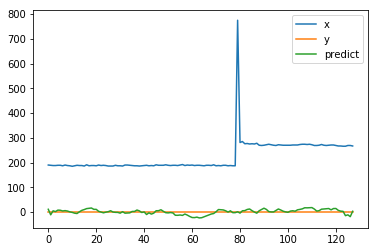

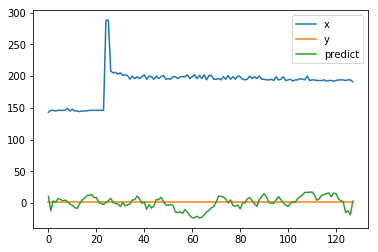

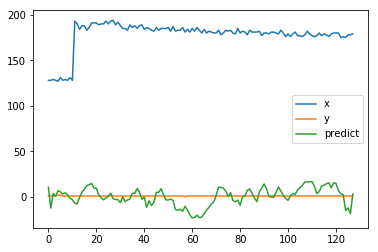

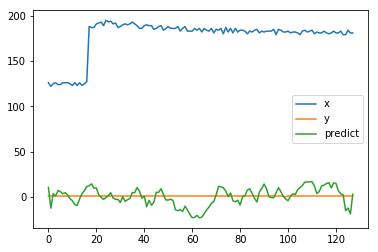

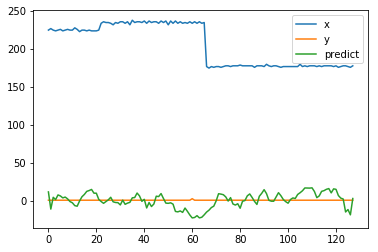

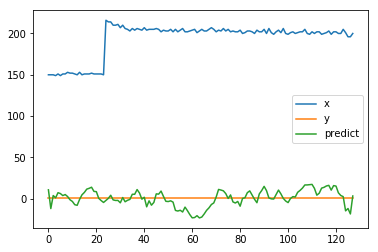

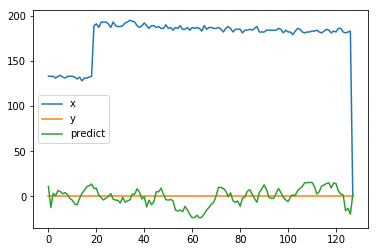

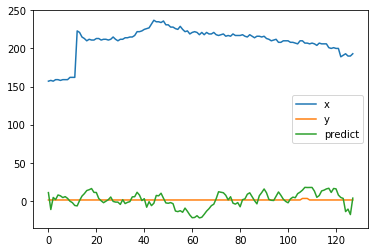

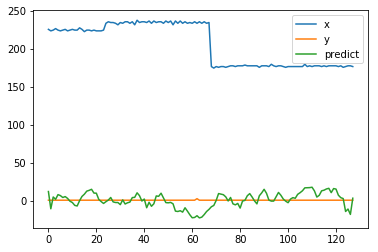

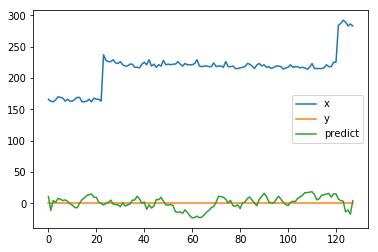

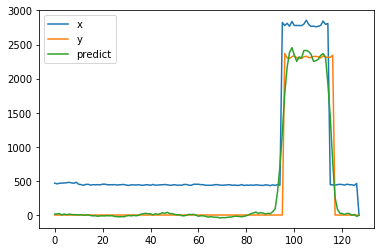

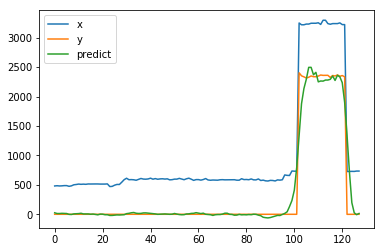

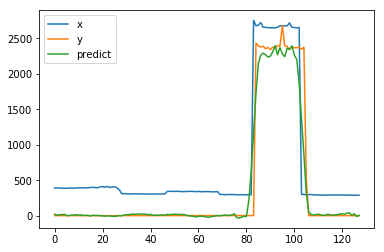

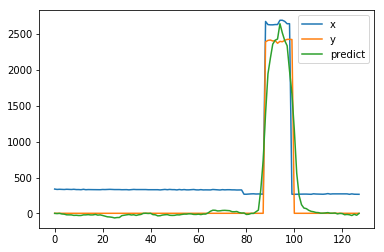

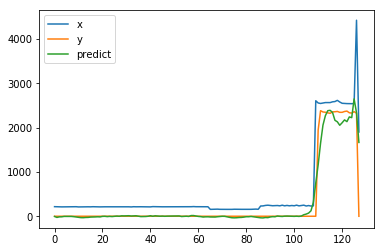

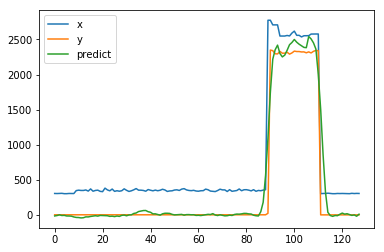

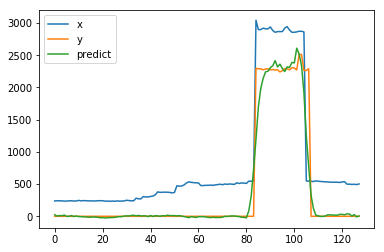

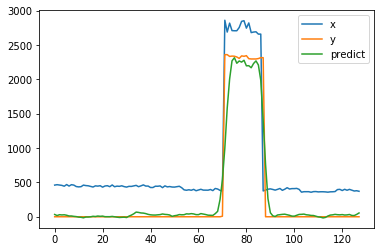

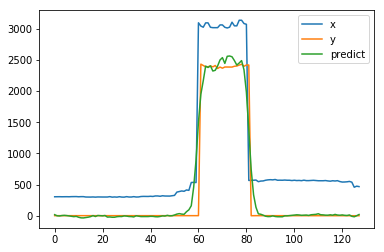

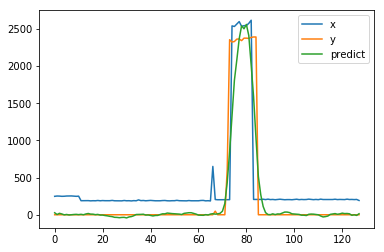

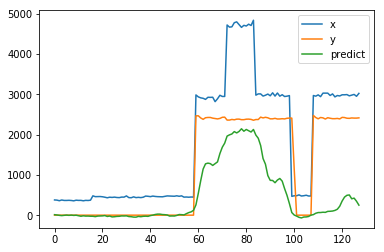

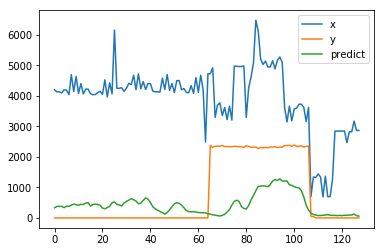

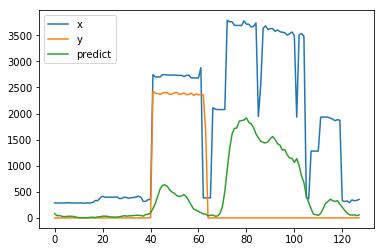

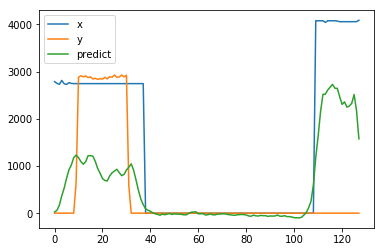

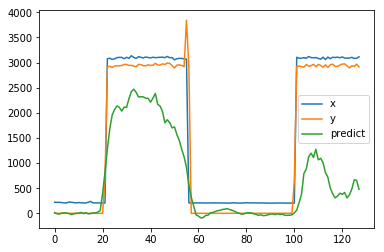

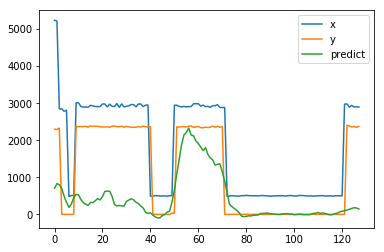

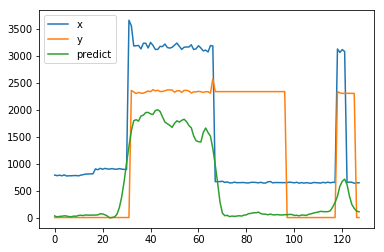

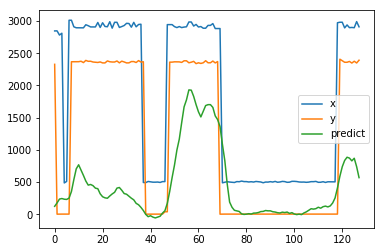

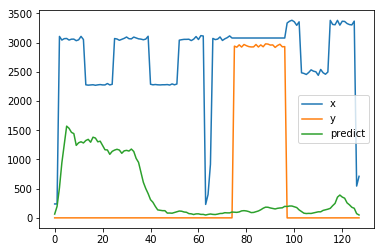

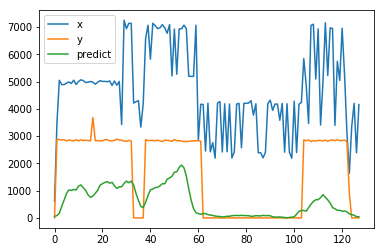

In [3]:
num_epochs = 3
BATCH_SIZE = 128
doTrain = True
doPlot = True

for appliance in [ appliance for appliance in APP_CONFIG.keys()]:
    # 1. loading data
    t = time.time()
    x_train, y_train, x_test, y_test, x_val, y_val = load_data(appliance, 
                                                               file='./data/dataset/dataset_x5.csv', 
                                                               data_proportion = [0.9, 0.95])
    print('Train: {} | Test: {} | Val: {}'.format(x_train.shape, x_test.shape, x_val.shape))
    
    # 2. std normalize data & reshape 2d (x, y) to 3d - >(x, y, 1)
    scaler = StandardScaler().fit(x_train)
    x_train, y_train, x_test, y_test, x_val, y_val = [ scaler.transform(d).reshape(tuple(list(d.shape) + [1]))
                                                      for d in [x_train, y_train, x_test, y_test, x_val, y_val]]
    print('time for loading data: {}s'.format(time.time() - t))

    sequence_length = x_train.shape[1]
    
    for model_name, model in [ o for o in getmembers(__DNN__.nn_models) if isfunction(o[1])]:
        current_model = model(sequence_length)

        if not os.path.exists('./result/'):
            os.makedirs('./result/') 
        weight_path = './result/{}_{}_{}epo.hdf5'.format(appliance, model_name, num_epochs)

        # 3. tranning
        t = time.time()
        if doTrain:   
            history = current_model.fit(
                x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=num_epochs,
                validation_data=(x_val, y_val),
                callbacks=[ModelCheckpoint(filepath=weight_path,verbose=0, save_best_only=True)]
            )
            print('### Total trainning time cost: {} ###'. format(time.time() - t))
        else:
            print('loading from {}'.format(weight_path))
            current_model.load_weights(weight_path)
        time_cost = time.time()-t

        # 4. evaluation   
        preds = scaler.inverse_transform(current_model.predict(x_test, verbose=0).reshape(y_test.shape[:-1]))
        y_truth = scaler.inverse_transform(y_test.reshape(y_test.shape[:-1]))

        mae = MAE(y_truth, preds)
        mape = MAPE(y_truth, preds)
        nrmse = NRMSE(y_truth, preds)
        total_mape = TOTAL_MAPE(y_truth, preds)

        if doTrain:
            # 5. save statsitic result
            save_history(appliance, model_name, time_cost, history, mae, mape, nrmse, total_mape)
        if doPlot:
            # 6. plot
            x = scaler.inverse_transform(x_test.reshape(x_test.shape[:-1]))
            num = 5
            y_std = y_truth.std(axis=0)
            
            # sort from wrost to best case
            list_idx = np.argsort(np.sqrt((np.square(y_truth-preds) / y_std)).sum(axis=1))
            # head, mid, tail. 10 for each
            idxs = np.concatenate([list_idx[:10], list_idx[list_idx.shape[0]//2:list_idx.shape[0]//2+10], list_idx[-10:]])
            for i in idxs:
                plt.plot(x[i], label="x")
                plt.plot(y_truth[i], label="y")
                plt.plot(preds[i], label="predict")
                plt.legend()
                plt.show()
        break
    break